In [57]:

# Imports
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [58]:
# Load and preprocess the data
data = pd.read_csv('Cell viability and extrusion dataset V1.csv')

# Fill missing temperature values with 22
data['Syringe_Temperature_(°C)'] = data['Syringe_Temperature_(°C)'].fillna(22)
data['Substrate_Temperature_(°C)'] = data['Substrate_Temperature_(°C)'].fillna(22)

# Drop columns with >=50% zeros or nulls
for column in data.columns:
    if ((data[column] == 0).sum() + data[column].isnull().sum()) / len(data[column]) >= 0.5:
        data.drop(column, axis=1, inplace=True)

# Drop known irrelevant columns if they exist
for col in ["Reference", "DOI"]:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)

# Clean specific columns
if "Fiber_Diameter_(µm)" in data.columns:
    data["Fiber_Diameter_(µm)"] = data["Fiber_Diameter_(µm)"].str.split(" ").str[0].astype(float)

if "Conical_or_Straight_Nozzle" in data.columns:
    data['Conical_or_Straight_Nozzle'] = data['Conical_or_Straight_Nozzle'].replace({'C': 0, 'S': 1}).astype(float)

# Define features and labels
drop_cols = ["Viability_at_time_of_observation_(%)", "Acceptable_Viability_(Yes/No)"]
drop_cols = [col for col in drop_cols if col in data.columns]  # only keep existing columns
Features = data.drop(columns=drop_cols)

# One-hot encode categorical columns (if needed)
OHE = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
Features_encoded = OHE.fit_transform(Features.select_dtypes(include=["object", "category"]))

# Combine with numerical columns
numerical_features = Features.select_dtypes(exclude=["object", "category"]).values
Features_combined = np.hstack([numerical_features, Features_encoded])

# Imputation
imputer = KNNImputer(n_neighbors=30, weights="uniform")
Features_imputed = imputer.fit_transform(Features_combined)

# Round specific column if needed
if Features_imputed.shape[1] > 16:  # check column index exists
    Features_imputed[:, 16] = Features_imputed[:, 16].round()

# Define x and y
x = pd.DataFrame(Features_imputed)
y = data["Viability_at_time_of_observation_(%)"].values


/var/folders/k_/hv17xzv51mx62w1gnkthp5r80000gn/T/ipykernel_57213/1961151734.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Conical_or_Straight_Nozzle'] = data['Conical_or_Straight_Nozzle'].replace({'C': 0, 'S': 1}).astype(float)



Training model: Random Forest

Training model: Linear Regression

Training model: Logistic Regression

Training model: Support Vector Classification


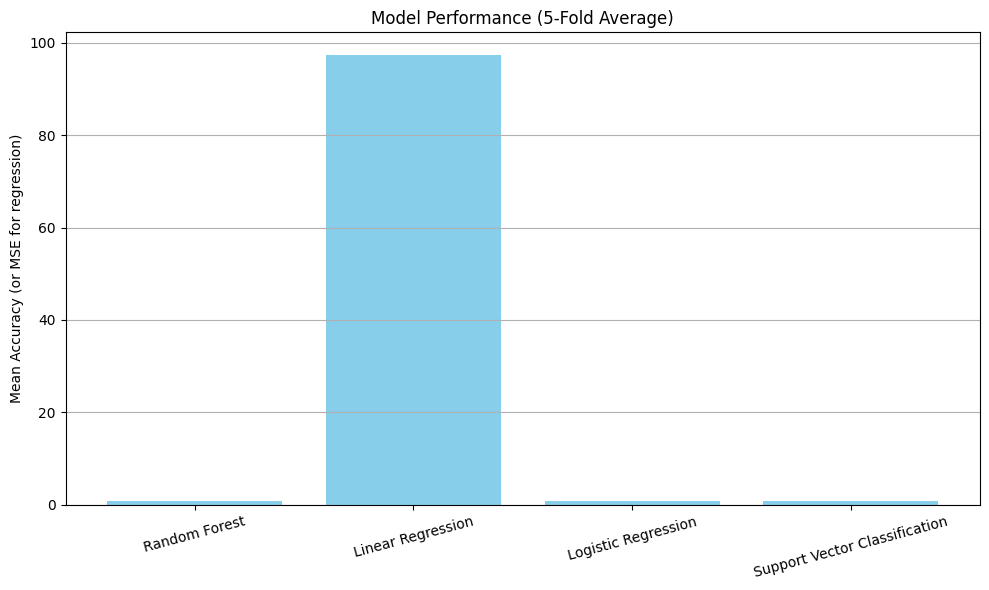

In [59]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "Linear Regression": LinearRegression(fit_intercept=True, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Classification": SVC()
}

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Classification target
y_classification = np.where(y > 50, 1, 0)

# Result storage
train_scores = {}
test_scores = {}
mse_results = {}
r2_results = {}

for model_name, model in models.items():
    print(f"\nTraining model: {model_name}")

    train_metrics = []
    test_metrics = []

    # Only needed for regression
    mse_list = []
    r2_list = []

    for train_idx, test_idx in kf.split(x):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train = y[train_idx] if model_name == "Linear Regression" else y_classification[train_idx]
        y_test = y[test_idx] if model_name == "Linear Regression" else y_classification[test_idx]

        # Scale features
        scaler = MinMaxScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Train and predict
        model.fit(x_train_scaled, y_train)
        y_train_pred = model.predict(x_train_scaled)
        y_test_pred = model.predict(x_test_scaled)

        if model_name == "Linear Regression":
            # MSE and R² for regression
            train_metrics.append(mean_squared_error(y_train, y_train_pred))
            test_metrics.append(mean_squared_error(y_test, y_test_pred))
            mse_list.append(mean_squared_error(y_test, y_test_pred))
            r2_list.append(r2_score(y_test, y_test_pred))
        else:
            # Accuracy for classification
            train_metrics.append(accuracy_score(y_train, y_train_pred))
            test_metrics.append(accuracy_score(y_test, y_test_pred))

    # Average results across folds
    train_scores[model_name] = np.mean(train_metrics)
    test_scores[model_name] = np.mean(test_metrics)

    if model_name == "Linear Regression":
        mse_results[model_name] = mse_list
        r2_results[model_name] = r2_list

# 📊 Plot average test performance
model_names = list(test_scores.keys())
avg_scores = list(test_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, avg_scores, color='skyblue')
plt.title("Model Performance (5-Fold Average)")
plt.ylabel("Mean Accuracy (or MSE for regression)")
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 📈 Plot MSE and R² if regression was used
if "Linear Regression" in mse_results:
    mse = mse_results["Linear Regression"]
    r2 = r2_results["Linear Regression"]
    folds = range(1, len(mse) + 1)

    mean_mse = np.mean(mse)
    mean_r2 = np.mean(r2)


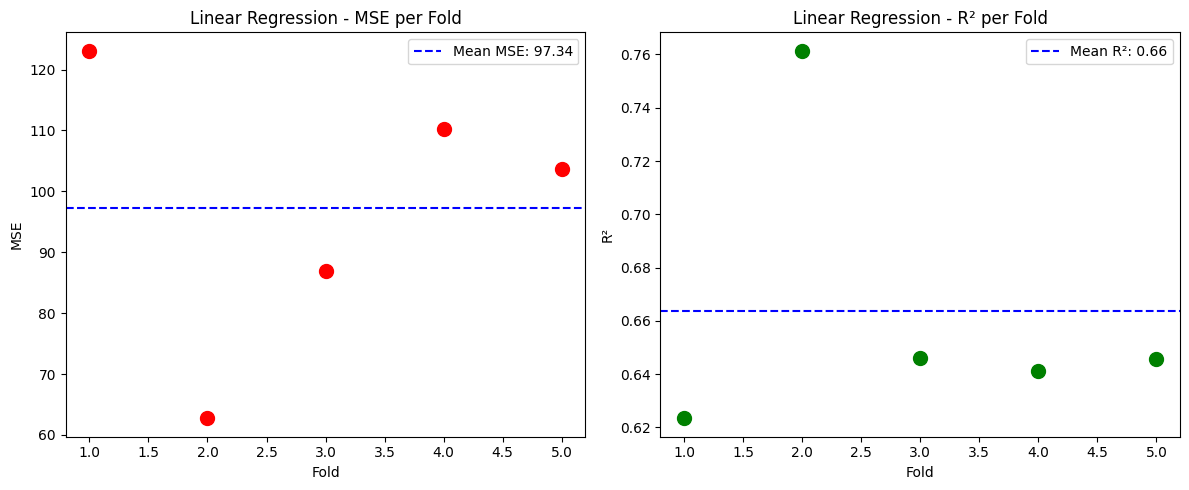

In [60]:

    plt.figure(figsize=(12, 5))

    # MSE plot
    plt.subplot(1, 2, 1)
    plt.scatter(folds, mse, color='red', s=100)
    plt.axhline(y=mean_mse, color='blue', linestyle='--', label=f"Mean MSE: {mean_mse:.2f}")
    plt.title("Linear Regression - MSE per Fold")
    plt.xlabel("Fold")
    plt.ylabel("MSE")
    plt.legend()

    # R² plot
    plt.subplot(1, 2, 2)
    plt.scatter(folds, r2, color='green', s=100)
    plt.axhline(y=mean_r2, color='blue', linestyle='--', label=f"Mean R²: {mean_r2:.2f}")
    plt.title("Linear Regression - R² per Fold")
    plt.xlabel("Fold")
    plt.ylabel("R²")
    plt.legend()

    plt.tight_layout()
    plt.show()